<center> <h1> Exploring and Predicting Characteristics of Japanese Newspaper Headlines </h1> </center>

<center> <h2> <i>STA208 Final Project (Spring 2017)</i> </h2> </center>
<center> <h3> <i>Tzu-ping Liu and Gento Kato</i> </h3> </center>

[*Back to Summary Notebook*](Project_Summary_STA208.ipynb)

<center> <h1> <i>Section V</i> </h1> </center>
<center> <h1> Predicting Negative Sentiments in Newspaper Headlines </h1> </center>

## 1. Purpose

Apply supervised learning methods to the data

## 2. Preparation

### 2.0 Import Required Packages

In [1]:
#%reset

In [2]:
## Data Mining
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Classification Method
from sklearn import preprocessing, neighbors ## KNN
import sklearn.linear_model as skl_lm ## Linear Methods (Logit)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis ## Linear Discricimant Analysis
from sklearn.svm import SVC ## Support Vector Machine 
from sklearn.naive_bayes import BernoulliNB ## Naive Bayes
from sklearn.ensemble import RandomForestClassifier ## Random Forest

## Model Selection and Metrics
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve
from sklearn.metrics import auc, roc_auc_score, average_precision_score

### 2.1 Load Data

In [3]:
## All Data
alldata = pd.read_csv("../../data/alldata_traincode_170510.csv", encoding='CP932')
allWrdMat10 = pd.read_csv("../../data/allWrdMat10.csv.gz", encoding='CP932')

## Test on Cabinet Data
#cabinetdata = pd.read_csv('../data_public/cabinetdata_traincode.csv', encoding='CP932', na_values='NA')
#cabinetWrdMat10 = pd.read_csv('../data_public/cabinetWrdMat10.csv', encoding='CP932', na_values='NA')

## Test on LDP Data
#ldpdata = pd.read_csv('../data_public/ldpdata_traincode.csv', encoding='CP932', na_values='NA')
#ldpWrdMat10 = pd.read_csv('../data_public/ldpWrdMat10.csv', encoding='CP932', na_values='NA')

## Test on Politics Data (FOR THIS EXAMPLE)
#politicsdata = pd.read_csv('../data_public/politicsdata_traincode.csv', encoding='CP932', na_values='NA')
#politicsWrdMat10 = pd.read_csv('../data_public/politicsWrdMat10.csv', encoding='CP932', na_values='NA')

In [ ]:
allWrdMat10_count = allWrdMat10.groupby(by=train).count()

In [18]:
alldata.head(3)

,id_all,id_inpaper,id_original,year,month,date,ymonth,Headline,paper,wcount,Asahi,Yomiuri,jijistartdate,jijiymonth,codeN,train
0,1,1,3,1987,11,7,198711,竹下首相任命式も皇太子殿下が出席,A,85.0,1.0,NaN,7,198711,NaN,0
1,2,2,4,1987,11,7,198711,米国務次官補、懸案協議へあす来日,A,426.0,1.0,NaN,7,198711,NaN,0
2,3,3,5,1987,11,7,198711,政策遂行は党主導か 竹下内閣発足＜解説＞,A,1033.0,1.0,NaN,7,198711,NaN,0


In [19]:
allWrdMat10.head(3)

,?,．,・,％,０,１,１０月,１１月,１２月,１つ,...,瀋陽,疆,盧,籠,絆,胚,諫早,趙,鉉,鎔基
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.2 Prepare Training Data and Testing Data

In [20]:
targetx = allWrdMat10
targety = alldata

X = np.array(targetx.loc[targety['train'] == 1,:])
y = np.array(targety.loc[targety['train'] == 1,'codeN'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

## 3. Conduct Classification (One Shot)

### 3.0 Function to Simulate the Result

In [59]:
def class_onestep_accu(X_train, y_train, X_test, y_test, clmod):
    """
    Store accuracy score from one-step classification method.
    
    Input: design matrix for code training, X_train, response vector for code training, y_train, 
           design matrix for code test, X_test, response vector for code training, y_test, 
           a classification model, clmod
    Output: Accuracy score, accuracy
    """
    clmod.fit(X_train,y_train) ## Fit Model on Training Data
    predy = clmod.predict(X_test)  # predicted Y (for test y)
    accuracy = accuracy_score(y_test,predy)
    return accuracy 

def class_onestep_auc(X_train, y_train, X_test, y_test, clmod):
    """
    Store AUC measures from one-step classification method.
    
    Input: design matrix for code training, X_train, response vector for code training, y_train, 
           design matrix for code test, X_test, response vector for code training, y_test, 
           a classification model, clmod
    Output: false positive rate, modfpr, true positive rate, modtpr, area under curve, modauc, 
            precision, modprec, recall, modrec, average precision, modprauc
    """
    clmod.fit(X_train,y_train) ## Fit Model on Training Data
    proby = clmod.predict_proba(X_test)[:,1]  # predicted Y (for test y)
    modfpr, modtpr, _  = roc_curve(y_test, proby) #ROC Curve
    modrocauc = auc(modfpr, modtpr) # Area Under Curve (AUC) for ROC
    modprec, modrec, _ = precision_recall_curve(y_test, proby) #PR Curve
    modprauc = auc(modrec, modprec) ## Average Precision from PR Curve
    return modfpr, modtpr, modrocauc, modprec, modrec, modprauc

def class_oneshot(X, y, clmod, testsize = .2, randomstate=2342):
    """
    Store test measures from one-shot classification methods.
    
    Input: design matrix, X, response vector, y, 
           a classification model, clmod, size of test set, testsize
    Output: false positive rate, modfpr, true positive rate, modtpr, area under curve, modauc, 
            precision, modprec, recall, modrec, average precision, modprav
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=randomstate) ## Train-Test Split
    modfpr, modtpr, modrocauc, modprec, modrec, modprauc = class_onestep_auc(X_train, y_train, X_test, y_test, clmod) ## Conduct one_step classification
    return modfpr, modtpr, modrocauc, modprec, modrec, modprauc

In [61]:
def class_validation(X, y, clmod, score_method = 'Accuracy', val_method = 'KFold', k = 5, testsize = 0.5, simuN=1, startrand = 3423):
    
    """
    Simulate and store test measures from k-fold cross-validation classification.
    
    Input: design matrix, X, response vector, y, 
           a classification model, clmod, itereation number, n
    Output: false positive rate, modfpr, true positive rate, modtpr, are under curve, modauc, precision, modprec, recall, modrec
    """
    
    modrocauc = np.array([])
    modprauc = np.array([])
    modaccu = np.array([])

    if score_method == 'Accuracy':
        
        if val_method == 'KFold':
            kf = KFold(n_splits = k)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                ## Conduct one_step classification
                modaccu_temp = class_onestep_accu(X_train, y_train, X_test, y_test, clmod) 
                ## Append Accuracy
                modaccu = np.append(modaccu,modaccu_temp)

        if val_method == 'LeaveOneOut':
            loo = LeaveOneOut()
            for train_index, test_index in loo.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                ## Conduct one_step classification
                modaccu_temp = class_onestep_accu(X_train, y_train, X_test, y_test, clmod) 
                ## Append Accuracies
                modaccu = np.append(modaccu,modaccu_temp)
        
        if val_method == 'HoldOut':
            for i in range(1, simuN+1):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=i+(startrand-1))
                ## Conduct one_step classification
                modaccu_temp = class_onestep_accu(X_train, y_train, X_test, y_test, clmod) 
                ## Append Accuracies
                modaccu = np.append(modaccu,modaccu_temp)
        
        return np.mean(modaccu)
            
    if score_method == 'AUC':
        
        if val_method == 'KFold':
            kf = KFold(n_splits = k)
            for train_index, test_index in kf.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                ## Conduct one_step classification
                _,_,modrocauc_temp,_,_,modprauc_temp = class_onestep_auc(X_train, y_train, X_test, y_test, clmod) 
                ## Append AUCs
                modrocauc = np.append(modrocauc,modrocauc_temp)
                modprauc = np.append(modprauc,modprauc_temp)
                
        if val_method == 'HoldOut':
            for i in range(1, simuN+1):
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=i+(startrand-1))
                ## Conduct one_step classification
                _,_,modrocauc_temp,_,_,modprauc_temp = class_onestep_auc(X_train, y_train, X_test, y_test, clmod) 
                ## Append AUCs
                modrocauc = np.append(modrocauc,modrocauc_temp)
                modprauc = np.append(modprauc,modprauc_temp)        
        
        return np.mean(modrocauc), np.mean(modprauc)            

### 3.1 K Nearest Neighbors

In [62]:
## With k 
k = 100
knn = neighbors.KNeighborsClassifier(n_neighbors=k) ##knn estimation

## On Test Set
knnfpr, knntpr, knnrocauc, knnprec, knnrec, knnprauc = class_oneshot(X, y, knn)

### 3.2 Logistic Regression (With Newton Conjugate Solver)

In [63]:
## Logistic Regression
logit = skl_lm.LogisticRegression(solver='newton-cg')

## On Test Set
logitfpr, logittpr, logitrocauc, logitprec, logitrec, logitprauc = class_oneshot(X, y, logit)

### 3.3 Linear Discriminant Analysis

In [64]:
## Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()

## On Test Set
ldafpr, ldatpr, ldarocauc, ldaprec, ldarec, ldaprauc = class_oneshot(X, y, lda)

### 3.4 Support Vector Machine

In [65]:
## Support Vector Machines
svmcl = SVC(probability=True)

## On Test Set
svmfpr, svmtpr, svmrocauc, svmprec, svmrec, svmprauc = class_oneshot(X, y, svmcl)

### 3.5 Bernoulli Naive Bayes 

In [66]:
## Bernoulli Naive Bayes
nb = BernoulliNB()
 
## On Test Set
nbfpr, nbtpr, nbrocauc, nbprec, nbrec, nbprauc = class_oneshot(X, y, nb)

### 3.5 Random Forest 

In [67]:
## Random Forest
rf = RandomForestClassifier(n_estimators=500)

## On Test Set
rffpr, rftpr, rfrocauc, rfprec, rfrec, rfprauc = class_oneshot(X, y, rf)

## 4. Compare The Result

### 4.1 ROC Curve

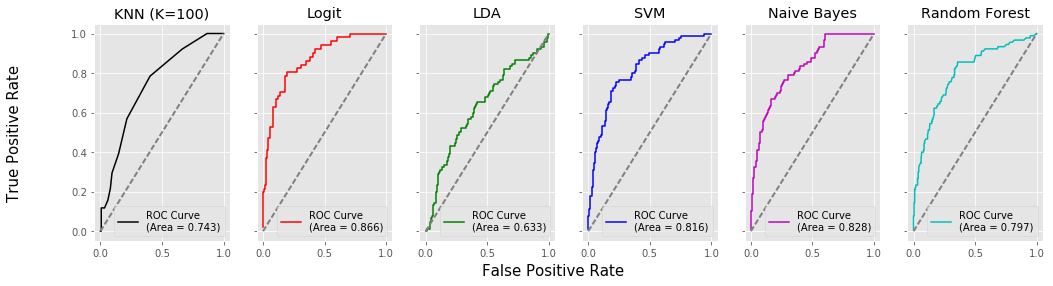

In [32]:
plt.rcParams["figure.figsize"] = (17,4)
f, (ax0, ax1, ax2, ax3, ax4, ax5),  = plt.subplots(1, 6, sharey=True)
f.text(0.5, 0.02, 'False Positive Rate', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'True Positive Rate', ha='center', va='center', rotation='vertical', fontsize = 15)

ax0.plot(knnfpr, knntpr, 'k-', label = 'ROC Curve \n(Area = %0.3f)' % knnrocauc)
ax0.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax0.set_title('KNN (K=100)');
ax0.set_xlim(-0.05,1.05)
ax0.set_ylim(-0.05,1.05)
ax0.legend(loc="lower right")

ax1.plot(logitfpr, logittpr, 'r-', label = 'ROC Curve \n(Area = %0.3f)' % logitrocauc)
ax1.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax1.set_title('Logit');
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(ldafpr, ldatpr, 'g-', label = 'ROC Curve \n(Area = %0.3f)' % ldarocauc)
ax2.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax2.set_title('LDA');
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(svmfpr, svmtpr, 'b-', label = 'ROC Curve \n(Area = %0.3f)' % svmrocauc)
ax3.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax3.set_title('SVM');
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(nbfpr, nbtpr, 'm-', label = 'ROC Curve \n(Area = %0.3f)' % nbrocauc)
ax4.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax4.set_title('Naive Bayes');
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

ax5.plot(rffpr, rftpr, 'c-', label = 'ROC Curve \n(Area = %0.3f)' % rfrocauc)
ax5.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
ax5.set_title('Random Forest');
ax5.set_xlim(-0.05,1.05)
ax5.set_ylim(-0.05,1.05)
ax5.legend(loc="lower right")

plt.show()

### 4.2 PR Curve

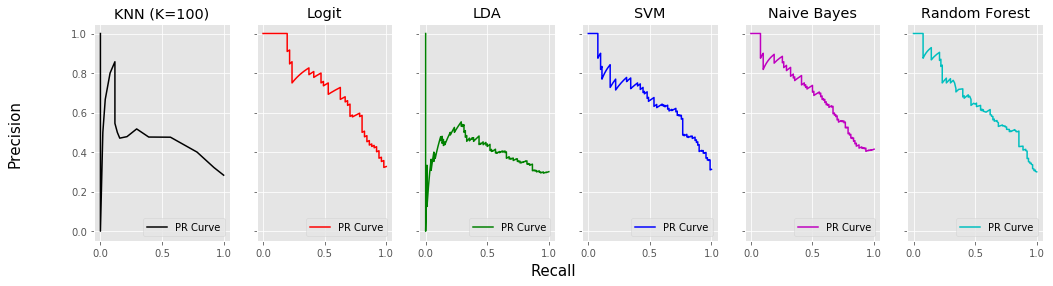

In [33]:
plt.rcParams["figure.figsize"] = (17,4)
f, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 6, sharey=True)
f.text(0.5, 0.02, 'Recall', ha='center', va='center', fontsize = 15)
f.text(0.06, 0.5, 'Precision', ha='center', va='center', rotation='vertical', fontsize = 15)

ax0.plot(knnrec, knnprec, 'k-', label = 'PR Curve \n(Area = %0.3f)' % knnprauc)
ax0.set_title('KNN (K=100)');
ax0.set_xlim(-0.05,1.05)
ax0.set_ylim(-0.05,1.05)
ax0.legend(loc="lower right")

ax1.plot(logitrec, logitprec, 'r-', label = 'PR Curve \n(Area = %0.3f)' % logitprauc)
ax1.set_title('Logit');
ax1.set_xlim(-0.05,1.05)
ax1.set_ylim(-0.05,1.05)
ax1.legend(loc="lower right")

ax2.plot(ldarec, ldaprec, 'g-', label = 'PR Curve \n(Area = %0.3f)' % ldaprauc)
ax2.set_title('LDA');
ax2.set_xlim(-0.05,1.05)
ax2.set_ylim(-0.05,1.05)
ax2.legend(loc="lower right")

ax3.plot(svmrec, svmprec, 'b-', label = 'PR Curve \n(Area = %0.3f)' % svmprauc)
ax3.set_title('SVM');
ax3.set_xlim(-0.05,1.05)
ax3.set_ylim(-0.05,1.05)
ax3.legend(loc="lower right")

ax4.plot(nbrec, nbprec, 'm-', label = 'PR Curve \n(Area = %0.3f)' % nbprauc)
ax4.set_title('Naive Bayes');
ax4.set_xlim(-0.05,1.05)
ax4.set_ylim(-0.05,1.05)
ax4.legend(loc="lower right")

ax5.plot(rfrec, rfprec, 'c-', label = 'PR Curve \n(Area = %0.3f)' % rfprauc)
ax5.set_title('Random Forest');
ax5.set_xlim(-0.05,1.05)
ax5.set_ylim(-0.05,1.05)
ax5.legend(loc="lower right")

plt.show()

## 5. Store the Result

### 5.1 Predictions of Full Dataset

In [4]:
def class_simpred(Xall, X, y, clmod, n, testsize = .2):
    """
    Simulate and store predicted probabilities from classification methods.
    
    Input: All design matrix, Xall, training design matrix, X, response vector, y, 
           a classification model, clmod, itereation number, n
    Output: predicted probabilities, probyA
    """
    probyA = np.array([]).reshape(0,X.shape[1])
    for i in range(1, n+1):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=i) ## Train-Test Split
        clmod.fit(X_train,y_train) ## Fit Model on Training Data
        probyA_temp = clmod.predict_proba(Xall)[:,1]  # predicted all Y (for All y)        
        probyA = np.vstack([probyA, probyA_temp])
    return probyA